# Combined Tier 1: Claim-Driven Research Orchestration (08-3)

This notebook implements a **new Phase 3 combined architecture** that unifies the validated Tier 1 paradigms while excluding the Experience Store for the first iteration.

**Included paradigms:**
- Iterative Refinement V2 (skeleton + patch-based refinement)
- Quality Gates (strategic checkpoints)
- Agile Sprints (evidence gathering only)
- Cascading Knowledge Cache (global search layer)

**Excluded (initially):** Experience Store (uncertain benefit in manual testing)

## Architecture Phases

1. **Phase A: Plan + Skeleton**
   - Generate document structure and claim placeholders
   - Gate 1 validates structure quality

2. **Phase B: Evidence Sprints**
   - Agile sprints to verify claim placeholders
   - Knowledge Cache wraps all searches
   - Gate 2 validates evidence sufficiency

3. **Phase C: Patch Construction**
   - Expand nodes with evidence-grounded prose and bridges
   - Gate 3 validates prose quality

4. **Phase D: Critique + Patch Loop**
   - Structured critique, targeted retrieval, patch application
   - Convergence-based stop

5. **Phase E: Finalization**
   - Assemble markdown and references

In [2]:
import os
import operator
import asyncio
import hashlib
import json
import re
import uuid
from pathlib import Path
from typing import List, Dict, Tuple, Annotated, TypedDict, Literal, Optional, Any
from datetime import datetime, timezone

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

import numpy as np

# Load environment variables
env_path = Path("../../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

# Models
MODEL_NAME = "gpt-5-mini-2025-08-07"
EMBEDDING_MODEL = "text-embedding-3-small"

llm = ChatOpenAI(model=MODEL_NAME, temperature=0, max_retries=10)
embeddings_model = OpenAIEmbeddings(model=EMBEDDING_MODEL)
tavily_client = TavilyClient()

# Phase A: Skeleton + claims
SKELETON_MIN_SECTIONS = 4
SKELETON_MAX_SECTIONS = 7
TARGET_WORDS_PER_SECTION = 300
GATE1_MAX_ATTEMPTS = 2

# Logging
LOG_EVENTS = True

# Phase B: Evidence sprints
MAX_SPRINTS = 3
CLAIMS_PER_SPRINT = 4
SEARCHES_PER_CLAIM = 3
MAX_RESULTS_PER_SEARCH = 6
GATE2_MAX_ATTEMPTS = 2
MIN_VERIFIED_RATE = 0.70
MIN_DOMAIN_DIVERSITY = 5

# Phase C: Prose construction
GATE3_COHERENCE_THRESHOLD = 7.0
GATE3_DEPTH_THRESHOLD = 7.0
GATE3_MAX_ATTEMPTS = 2
DOC_WORD_RANGE = (1200, 2500)

# Phase D: Refinement
MAX_REFINEMENT_ITERATIONS = 2
QUALITY_THRESHOLD = 8.0
MIN_IMPROVEMENT_THRESHOLD = 0.3
MAX_CASCADE_DEPTH = 2

# Knowledge Cache
CHUNK_SIZE = 500
CHUNK_OVERLAP = 100
HIGH_CONFIDENCE_THRESHOLD = 0.75
LOW_CONFIDENCE_THRESHOLD = 0.40
SPECIFICITY_ADJUSTMENT = 0.2
TOP_K_RETRIEVAL = 5

# Source quality + citations
MAX_CITATIONS_PER_SECTION = 4
MAX_REFERENCES = 60
CITATION_SELECTION_TOP_K = 6

print("Environment configured successfully")
print(f"Model: {MODEL_NAME}")
print(f"Embeddings: {EMBEDDING_MODEL}")

Environment configured successfully
Model: gpt-5-mini-2025-08-07
Embeddings: text-embedding-3-small


In [3]:
class CachedDocument(BaseModel):
    url: str
    normalized_url: str
    content: str
    content_hash: str
    title: str = ""
    retrieval_timestamp: str = ""
    source_query: str = ""


class CachedChunk(BaseModel):
    chunk_id: str
    text: str
    embedding: List[float]
    source_url: str
    position: int


class QueryCacheEntry(BaseModel):
    original_query: str
    light_normalized: str
    aggressive_normalized: str
    timestamp: str
    result_urls: List[str]
    result_summary: str


class CacheDecision(BaseModel):
    query: str
    layer_reached: Literal["L1", "L2", "L3"]
    decision: Literal["HIT", "HIGH_CONF", "MEDIUM_CONF", "LOW_CONF", "SUFFICIENT", "PARTIAL", "INSUFFICIENT"]
    confidence_score: float = 0.0
    action_taken: Literal["USE_CACHE", "SEARCH", "TARGETED_SEARCH"]
    reasoning: str = ""
    timestamp: str = ""


class L3Decision(BaseModel):
    verdict: Literal["SUFFICIENT", "PARTIAL", "INSUFFICIENT"]
    reasoning: str
    gap_queries: List[str] = Field(default_factory=list)


class CacheResult(BaseModel):
    content: str
    source_urls: List[str]
    decision: CacheDecision


def normalize_url(url: str) -> str:
    if not url:
        return ""
    url = url.strip()
    url = re.sub(r"^https?://", "", url)
    url = re.sub(r"^www\.", "", url)
    url = url.split("#")[0]
    url = url.split("?")[0]
    return url.lower()


URL_REGEX = re.compile(r"https?://[^\s\]\)]+")


def dedupe_preserve_order(items: List[str]) -> List[str]:
    seen = set()
    out = []
    for item in items:
        if item and item not in seen:
            seen.add(item)
            out.append(item)
    return out


def clean_citations(citations: List[str]) -> List[str]:
    cleaned: List[str] = []
    for item in citations:
        if not item:
            continue
        matches = URL_REGEX.findall(str(item))
        if matches:
            cleaned.extend(matches)
        else:
            cleaned.append(str(item).strip())
    cleaned = [c for c in cleaned if c.startswith("http")]
    return dedupe_preserve_order(cleaned)


def normalize_query_light(query: str) -> str:
    return re.sub(r"\s+", " ", query.strip().lower())


def normalize_query_aggressive(query: str) -> str:
    tokens = re.findall(r"[a-z0-9]+", query.lower())
    stop = {"the", "a", "an", "of", "for", "and", "to", "in", "on", "with", "by", "from"}
    tokens = [t for t in tokens if t not in stop]
    tokens = sorted(set(tokens))
    return " ".join(tokens)


def chunk_text(text: str, chunk_size: int, overlap: int) -> List[str]:
    if not text:
        return []
    chunks = []
    start = 0
    while start < len(text):
        end = min(start + chunk_size, len(text))
        chunks.append(text[start:end])
        start = end - overlap
        if start < 0:
            start = 0
        if end == len(text):
            break
    return chunks


def jaccard_overlap(a: str, b: str) -> float:
    a_tokens = set(re.findall(r"[a-z0-9]+", a.lower()))
    b_tokens = set(re.findall(r"[a-z0-9]+", b.lower()))
    if not a_tokens or not b_tokens:
        return 0.0
    return len(a_tokens & b_tokens) / len(a_tokens | b_tokens)


def estimate_specificity(query: str) -> float:
    numbers = len(re.findall(r"\d+", query))
    proper = len(re.findall(r"\b[A-Z][a-z]+\b", query))
    length = len(query.split())
    score = min(1.0, 0.1 * numbers + 0.05 * proper + 0.03 * length)
    return max(0.0, min(1.0, score))


def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


class KnowledgeBase:
    def __init__(self):
        self.url_registry: Dict[str, CachedDocument] = {}
        self.query_cache_light: Dict[str, QueryCacheEntry] = {}
        self.query_cache_bow: Dict[str, QueryCacheEntry] = {}
        self.chunks: List[CachedChunk] = []
        self.embeddings_matrix: Optional[np.ndarray] = None
        self.stats = {
            "total_queries": 0,
            "l1_hits": 0,
            "l2_high": 0,
            "l2_medium": 0,
            "l2_low": 0,
            "l3_sufficient": 0,
            "l3_partial": 0,
            "l3_insufficient": 0,
            "web_searches_executed": 0,
            "web_searches_avoided": 0,
        }
        self.decisions: List[CacheDecision] = []

    def add_query_result(self, query: str, urls: List[str], summary: str) -> None:
        light = normalize_query_light(query)
        aggressive = normalize_query_aggressive(query)
        entry = QueryCacheEntry(
            original_query=query,
            light_normalized=light,
            aggressive_normalized=aggressive,
            timestamp=datetime.now(timezone.utc).isoformat(),
            result_urls=urls,
            result_summary=summary,
        )
        self.query_cache_light[light] = entry
        if aggressive:
            self.query_cache_bow[aggressive] = entry

    def add_document(self, url: str, content: str, title: str = "", source_query: str = "") -> None:
        if not url or not content:
            return
        normalized = normalize_url(url)
        content_hash = hashlib.sha256(content.encode("utf-8")).hexdigest()
        if normalized in self.url_registry:
            return
        doc = CachedDocument(
            url=url,
            normalized_url=normalized,
            content=content,
            content_hash=content_hash,
            title=title,
            retrieval_timestamp=datetime.now(timezone.utc).isoformat(),
            source_query=source_query,
        )
        self.url_registry[normalized] = doc
        chunks = chunk_text(content, CHUNK_SIZE, CHUNK_OVERLAP)
        if chunks:
            embeds = embeddings_model.embed_documents(chunks)
            for idx, (chunk, emb) in enumerate(zip(chunks, embeds)):
                self.chunks.append(
                    CachedChunk(
                        chunk_id=f"{normalized}:{idx}",
                        text=chunk,
                        embedding=emb,
                        source_url=url,
                        position=idx,
                    )
                )
            self._refresh_embedding_matrix()

    def _refresh_embedding_matrix(self) -> None:
        if not self.chunks:
            self.embeddings_matrix = None
            return
        self.embeddings_matrix = np.array([c.embedding for c in self.chunks])

    def check_layer_1(self, query: str) -> Optional[QueryCacheEntry]:
        light = normalize_query_light(query)
        aggressive = normalize_query_aggressive(query)
        if light in self.query_cache_light:
            return self.query_cache_light[light]
        if aggressive in self.query_cache_bow:
            return self.query_cache_bow[aggressive]
        return None

    def check_layer_2(self, query: str) -> Tuple[str, float, List[CachedChunk]]:
        if self.embeddings_matrix is None or len(self.chunks) == 0:
            return "LOW", 0.0, []
        q_emb = np.array(embeddings_model.embed_query(query))
        scores = [cosine_similarity(q_emb, emb) for emb in self.embeddings_matrix]
        if not scores:
            return "LOW", 0.0, []
        top_idx = np.argsort(scores)[-TOP_K_RETRIEVAL:][::-1]
        top_scores = [scores[i] for i in top_idx]
        candidates = [self.chunks[i] for i in top_idx]
        top_score = top_scores[0]
        gap = top_scores[0] - top_scores[1] if len(top_scores) > 1 else top_scores[0]
        overlap = jaccard_overlap(query, candidates[0].text)
        specificity = estimate_specificity(query)
        adjusted_high = HIGH_CONFIDENCE_THRESHOLD + SPECIFICITY_ADJUSTMENT * specificity
        adjusted_low = LOW_CONFIDENCE_THRESHOLD + SPECIFICITY_ADJUSTMENT * specificity
        confidence_score = (top_score * 0.7) + (gap * 0.2) + (overlap * 0.1)
        if confidence_score >= adjusted_high:
            return "HIGH", confidence_score, candidates
        if confidence_score < adjusted_low:
            return "LOW", confidence_score, candidates
        return "MEDIUM", confidence_score, candidates

    async def check_layer_3(self, query: str, candidates: List[CachedChunk]) -> L3Decision:
        prompt = (
            "You are judging whether cached content is sufficient to answer a search query.\n\n"
            f"QUERY: {query}\n\n"
            "CANDIDATE SNIPPETS:\n"
            + "\n---\n".join([c.text[:400] for c in candidates])
            + "\n\n"
            "Decide if the cached content is SUFFICIENT, PARTIAL, or INSUFFICIENT.\n"
            "If PARTIAL, provide 1-3 gap queries to fill missing evidence."
        )
        judge = llm.with_structured_output(L3Decision)
        return await judge.ainvoke([HumanMessage(content=prompt)])

    def record_decision(self, decision: CacheDecision) -> None:
        decision.timestamp = datetime.now(timezone.utc).isoformat()
        self.decisions.append(decision)

    def get_stats_summary(self) -> str:
        total = max(self.stats["total_queries"], 1)
        hit_rate = (self.stats["l1_hits"] + self.stats["l2_high"] + self.stats["l3_sufficient"]) / total
        return (
            f"Total queries: {self.stats['total_queries']}, "
            f"Hit rate: {hit_rate:.2%}, "
            f"Web searches: {self.stats['web_searches_executed']}"
        )


def log_step(message: str) -> None:
    if not LOG_EVENTS:
        return
    timestamp = datetime.now(timezone.utc).isoformat()
    print(f"[{timestamp}] {message}")


knowledge_base: Optional[KnowledgeBase] = None


def format_search_results(results: List[Dict[str, Any]]) -> str:
    parts = []
    for r in results:
        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content", "")
        parts.append(f"Title: {title}\nURL: {url}\nContent: {content}\n")
    return "\n".join(parts)


def extract_urls(results: List[Dict[str, Any]]) -> List[str]:
    urls = [r.get("url", "") for r in results if r.get("url")]
    return dedupe_preserve_order(urls)


def extract_domains(urls: List[str]) -> List[str]:
    domains = []
    for u in urls:
        nu = normalize_url(u)
        if nu:
            domains.append(nu.split("/")[0])
    return list(set(domains))


def search_web(query: str, max_results: int = MAX_RESULTS_PER_SEARCH) -> List[Dict[str, Any]]:
    try:
        resp = tavily_client.search(query=query, max_results=max_results)
        return resp.get("results", [])
    except Exception as exc:
        print(f"Search error for query '{query}': {exc}")
        return []


async def cache_aware_search(query: str, kb: KnowledgeBase, purpose: str) -> CacheResult:
    kb.stats["total_queries"] += 1

    # Layer 1
    entry = kb.check_layer_1(query)
    if entry:
        kb.stats["l1_hits"] += 1
        kb.stats["web_searches_avoided"] += 1
        decision = CacheDecision(
            query=query,
            layer_reached="L1",
            decision="HIT",
            action_taken="USE_CACHE",
            reasoning="Exact or normalized query match",
        )
        kb.record_decision(decision)
        return CacheResult(content=entry.result_summary, source_urls=entry.result_urls, decision=decision)

    # Layer 2
    confidence, score, candidates = kb.check_layer_2(query)
    if confidence == "HIGH":
        kb.stats["l2_high"] += 1
        kb.stats["web_searches_avoided"] += 1
        decision = CacheDecision(
            query=query,
            layer_reached="L2",
            decision="HIGH_CONF",
            confidence_score=score,
            action_taken="USE_CACHE",
            reasoning="High semantic similarity",
        )
        kb.record_decision(decision)
        content = "\n".join([c.text[:400] for c in candidates])
        urls = list({c.source_url for c in candidates})
        return CacheResult(content=content, source_urls=urls, decision=decision)

    if confidence == "LOW":
        kb.stats["l2_low"] += 1
        results = search_web(query)
        kb.stats["web_searches_executed"] += 1
        urls = extract_urls(results)
        summary = format_search_results(results)
        kb.add_query_result(query, urls, summary)
        for r in results:
            kb.add_document(r.get("url", ""), r.get("content", ""), r.get("title", ""), query)
        decision = CacheDecision(
            query=query,
            layer_reached="L2",
            decision="LOW_CONF",
            confidence_score=score,
            action_taken="SEARCH",
            reasoning="Low semantic similarity",
        )
        kb.record_decision(decision)
        return CacheResult(content=summary, source_urls=urls, decision=decision)

    kb.stats["l2_medium"] += 1

    # Layer 3
    l3 = await kb.check_layer_3(query, candidates)
    if l3.verdict == "SUFFICIENT":
        kb.stats["l3_sufficient"] += 1
        kb.stats["web_searches_avoided"] += 1
        decision = CacheDecision(
            query=query,
            layer_reached="L3",
            decision="SUFFICIENT",
            confidence_score=score,
            action_taken="USE_CACHE",
            reasoning=l3.reasoning,
        )
        kb.record_decision(decision)
        content = "\n".join([c.text[:400] for c in candidates])
        urls = list({c.source_url for c in candidates})
        return CacheResult(content=content, source_urls=urls, decision=decision)

    if l3.verdict == "PARTIAL":
        kb.stats["l3_partial"] += 1
        decision = CacheDecision(
            query=query,
            layer_reached="L3",
            decision="PARTIAL",
            confidence_score=score,
            action_taken="TARGETED_SEARCH",
            reasoning=l3.reasoning,
        )
        kb.record_decision(decision)
        combined_results = []
        for gap_q in l3.gap_queries[:2]:
            combined_results.extend(search_web(gap_q))
        kb.stats["web_searches_executed"] += 1
        urls = extract_urls(combined_results)
        summary = format_search_results(combined_results)
        kb.add_query_result(query, urls, summary)
        for r in combined_results:
            kb.add_document(r.get("url", ""), r.get("content", ""), r.get("title", ""), query)
        cached_content = "\n".join([c.text[:400] for c in candidates])
        return CacheResult(content=cached_content + "\n" + summary, source_urls=urls, decision=decision)

    kb.stats["l3_insufficient"] += 1
    results = search_web(query)
    kb.stats["web_searches_executed"] += 1
    urls = extract_urls(results)
    summary = format_search_results(results)
    kb.add_query_result(query, urls, summary)
    for r in results:
        kb.add_document(r.get("url", ""), r.get("content", ""), r.get("title", ""), query)
    decision = CacheDecision(
        query=query,
        layer_reached="L3",
        decision="INSUFFICIENT",
        confidence_score=score,
        action_taken="SEARCH",
        reasoning=l3.reasoning,
    )
    kb.record_decision(decision)
    return CacheResult(content=summary, source_urls=urls, decision=decision)

In [4]:
class SkeletonNode(BaseModel):
    node_id: str
    title: str
    intent: str
    dependencies: List[str] = Field(default_factory=list)


class DocumentSkeleton(BaseModel):
    thesis: str
    nodes: List[SkeletonNode]


class Claim(BaseModel):
    claim_id: str
    node_id: str
    text: str
    priority: Literal["high", "medium", "low"] = "medium"
    status: Literal["placeholder", "unverified", "verified", "contested"] = "placeholder"
    evidence_urls: List[str] = Field(default_factory=list)


class EvidenceItem(BaseModel):
    claim_id: str
    url: str
    snippet: str
    support: Literal["supports", "weak", "contested"] = "supports"


class ResearchTask(BaseModel):
    claim_id: str
    queries: List[str]
    priority: Literal["high", "medium", "low"]
    status: Literal["pending", "in_progress", "done"] = "pending"


class ProseEntry(BaseModel):
    node_id: str
    title: str
    bridge_in: str
    body: str
    bridge_out: str
    summary: str
    citations: List[str] = Field(default_factory=list)


class NoiseIssue(BaseModel):
    issue_id: str
    scope: Literal["global", "section", "transition", "claim"]
    target_nodes: List[str]
    issue_type: str
    severity: int
    search_query: str = ""
    suggestion: str = ""
    affected_claims: List[str] = Field(default_factory=list)


class NoiseMap(BaseModel):
    overall_score: float
    issues: List[NoiseIssue] = Field(default_factory=list)


class PhaseScores(BaseModel):
    gate1: float = 0.0
    gate2: float = 0.0
    gate3: float = 0.0
    refinement: float = 0.0


class PlanningOutput(BaseModel):
    thesis: str
    key_entities: List[str]
    question_type: Literal["factual", "comparative", "causal", "analytical", "definitional"]


class SkeletonOutput(BaseModel):
    thesis: str
    nodes: List[SkeletonNode]


class ClaimPlaceholder(BaseModel):
    node_id: str
    claim_text: str
    priority: Literal["high", "medium", "low"]


class ClaimsOutput(BaseModel):
    claims: List[ClaimPlaceholder]


class ClaimQueries(BaseModel):
    claim_id: str
    queries: List[str]


class ClaimQueryOutput(BaseModel):
    items: List[ClaimQueries]


class GateScore(BaseModel):
    overall: float
    pass_gate: bool
    reasoning: str


class ProseGateScore(BaseModel):
    coherence: float
    depth: float
    pass_gate: bool
    reasoning: str


class CritiqueOutput(BaseModel):
    overall_score: float
    issues: List[NoiseIssue]


class CombinedState(TypedDict):
    question: str

    # Phase A
    thesis: str
    key_entities: List[str]
    question_type: str
    skeleton: DocumentSkeleton
    claims_registry: Dict[str, Claim]
    research_backlog: List[ResearchTask]
    gate1_attempts: int
    gate1_passed: bool
    gate1_reasoning: str

    # Phase B
    evidence_map: Dict[str, List[EvidenceItem]]
    source_urls: List[str]
    sprint_summaries: List[str]
    sprint_count: int
    gate2_attempts: int
    gate2_passed: bool

    # Phase C
    prose_store: Dict[str, ProseEntry]
    draft_document: str
    gate3_passed: bool
    gate3_reasoning: str
    gate3_word_count: int
    gate3_attempts: int
    gate3_failures: List[str]
    gate3_guidance: str
    gate3_focus_citations: bool
    section_word_target: int

    # Phase D
    noise_map: NoiseMap
    patch_queue: List[NoiseIssue]
    issue_evidence: Dict[str, List[EvidenceItem]]
    iteration_count: int
    prior_refinement_score: float
    quality_scores: PhaseScores

    # Output
    final_report: str
    references: str
    cache_stats: Dict[str, Any]


def init_state(question: str) -> CombinedState:
    return {
        "question": question,
        "thesis": "",
        "key_entities": [],
        "question_type": "analytical",
        "skeleton": DocumentSkeleton(thesis="", nodes=[]),
        "claims_registry": {},
        "research_backlog": [],
        "gate1_attempts": 0,
        "gate1_passed": False,
        "gate1_reasoning": "",
        "evidence_map": {},
        "source_urls": [],
        "sprint_summaries": [],
        "sprint_count": 0,
        "gate2_attempts": 0,
        "gate2_passed": False,
        "prose_store": {},
        "draft_document": "",
        "gate3_passed": False,
        "gate3_reasoning": "",
        "gate3_word_count": 0,
        "gate3_attempts": 0,
        "gate3_failures": [],
        "gate3_guidance": "",
        "gate3_focus_citations": False,
        "section_word_target": TARGET_WORDS_PER_SECTION,
        "noise_map": NoiseMap(overall_score=0.0, issues=[]),
        "patch_queue": [],
        "issue_evidence": {},
        "iteration_count": 0,
        "prior_refinement_score": 0.0,
        "quality_scores": PhaseScores(),
        "final_report": "",
        "references": "",
        "cache_stats": {},
    }

In [5]:
class ProseOutput(BaseModel):
    bridge_in: str
    body: str
    bridge_out: str
    summary: str
    citations: List[str] = Field(default_factory=list)


def format_skeleton(skeleton: DocumentSkeleton) -> str:
    lines = [f"Thesis: {skeleton.thesis}"]
    for node in skeleton.nodes:
        deps = ", ".join(node.dependencies) if node.dependencies else "none"
        lines.append(f"- {node.node_id}: {node.title} | intent={node.intent} | deps={deps}")
    return "\n".join(lines)


def topological_sort(nodes: List[SkeletonNode]) -> List[SkeletonNode]:
    if not nodes:
        return []
    node_map = {n.node_id: n for n in nodes}
    in_degree = {n.node_id: 0 for n in nodes}
    for n in nodes:
        for dep in n.dependencies:
            if dep in in_degree:
                in_degree[n.node_id] += 1
    queue = [node_id for node_id, degree in in_degree.items() if degree == 0]
    ordered = []
    while queue:
        current = queue.pop(0)
        ordered.append(node_map[current])
        for n in nodes:
            if current in n.dependencies:
                in_degree[n.node_id] -= 1
                if in_degree[n.node_id] == 0:
                    queue.append(n.node_id)
    if len(ordered) != len(nodes):
        return nodes
    return ordered


def claims_by_node(claims_registry: Dict[str, Claim]) -> Dict[str, List[Claim]]:
    out: Dict[str, List[Claim]] = {}
    for claim in claims_registry.values():
        out.setdefault(claim.node_id, []).append(claim)
    return out


def compact_url(url: str) -> str:
    normalized = normalize_url(url)
    if not normalized:
        return url
    return normalized.split("/")[0]


def format_sources_line(urls: List[str]) -> str:
    cleaned = clean_citations(urls)
    cleaned = dedupe_preserve_order(cleaned)[:MAX_CITATIONS_PER_SECTION]
    if not cleaned:
        return ""
    domains = [compact_url(u) for u in cleaned]
    return ", ".join(domains)


def rank_citations_for_node(state: CombinedState, node_id: str) -> List[str]:
    claim_map = claims_by_node(state["claims_registry"])
    claims = claim_map.get(node_id, [])
    url_scores: Dict[str, float] = {}
    for claim in claims:
        for item in state["evidence_map"].get(claim.claim_id, []):
            if not item.url:
                continue
            score = jaccard_overlap(claim.text, item.snippet)
            url_scores[item.url] = max(url_scores.get(item.url, 0.0), score)
    ranked = sorted(url_scores.items(), key=lambda x: x[1], reverse=True)
    urls = [u for u, _ in ranked]
    if not urls:
        for claim in claims:
            urls.extend(claim.evidence_urls)
    return dedupe_preserve_order(urls)[:CITATION_SELECTION_TOP_K]


def collect_citations_from_prose(prose_store: Dict[str, ProseEntry]) -> List[str]:
    citations: List[str] = []
    for entry in prose_store.values():
        if entry.citations:
            citations.extend(entry.citations)
        if entry.body:
            citations.extend(URL_REGEX.findall(entry.body))
    citations = clean_citations(citations)
    return dedupe_preserve_order(citations)


def build_references(urls: List[str]) -> str:
    cleaned = clean_citations(urls)
    cleaned = dedupe_preserve_order(cleaned)
    if not cleaned:
        return ""
    if MAX_REFERENCES:
        cleaned = cleaned[:MAX_REFERENCES]
    lines = ["## References"] + [f"{idx + 1}. {u}" for idx, u in enumerate(cleaned)]
    return "\n".join(lines)


async def preliminary_research(state: CombinedState) -> CombinedState:
    log_step("Phase A: preliminary_research")
    prompt = (
        "You are preparing a deep research plan. "
        "Produce a clear thesis statement, key entities, and a question type label.\n\n"
        f"QUESTION: {state['question']}"
    )
    planner = llm.with_structured_output(PlanningOutput)
    output = await planner.ainvoke([HumanMessage(content=prompt)])
    state["thesis"] = output.thesis
    state["key_entities"] = output.key_entities
    state["question_type"] = output.question_type
    log_step("Phase A: preliminary_research complete")
    return state


async def generate_skeleton(state: CombinedState) -> CombinedState:
    log_step("Phase A: generate_skeleton")
    prompt = (
        "Create a document skeleton for the research question.\n"
        f"Requirements: {SKELETON_MIN_SECTIONS}-{SKELETON_MAX_SECTIONS} sections, "
        "each with node_id, title, intent, and dependency list.\n"
        "Use short node_id values like s1, s2, s3. Dependencies must form a DAG.\n\n"
        f"QUESTION: {state['question']}\n"
        f"THESIS: {state['thesis']}\n"
    )
    generator = llm.with_structured_output(SkeletonOutput)
    output = await generator.ainvoke([HumanMessage(content=prompt)])
    state["skeleton"] = DocumentSkeleton(thesis=output.thesis, nodes=output.nodes)
    log_step(f"Phase A: generate_skeleton complete | sections={len(output.nodes)}")
    return state


async def identify_claims(state: CombinedState) -> CombinedState:
    log_step("Phase A: identify_claims")
    skeleton = state["skeleton"]
    prompt = (
        "For each skeleton node, generate 2-3 concrete, searchable claim placeholders. "
        "Return claim_text and priority (high, medium, low) for each node. "
        "Use node_id values exactly as shown in the skeleton.\n\n"
        f"SKELETON:\n{format_skeleton(skeleton)}"
    )
    generator = llm.with_structured_output(ClaimsOutput)
    output = await generator.ainvoke([HumanMessage(content=prompt)])
    claims_registry: Dict[str, Claim] = {}
    for item in output.claims:
        claim_id = f"claim_{uuid.uuid4().hex[:8]}"
        claims_registry[claim_id] = Claim(
            claim_id=claim_id,
            node_id=item.node_id,
            text=item.claim_text,
            priority=item.priority,
            status="unverified",
        )
    state["claims_registry"] = claims_registry
    log_step(f"Phase A: identify_claims complete | claims={len(claims_registry)}")
    return state


async def create_claim_backlog(state: CombinedState) -> CombinedState:
    log_step("Phase A: create_claim_backlog")
    claims = list(state["claims_registry"].values())
    if not claims:
        state["research_backlog"] = []
        return state
    claim_lines = [f"{c.claim_id}: {c.text}" for c in claims]
    prompt = (
        "Generate 2-3 high quality search queries per claim.\n"
        "Keep queries concise and evidence-seeking.\n"
        "Return queries keyed by the exact claim_id provided.\n\n"
        "CLAIMS:\n" + "\n".join(claim_lines)
    )
    generator = llm.with_structured_output(ClaimQueryOutput)
    output = await generator.ainvoke([HumanMessage(content=prompt)])

    query_map = {item.claim_id: item.queries for item in output.items}
    backlog: List[ResearchTask] = []
    for claim in claims:
        queries = query_map.get(claim.claim_id, [claim.text])
        backlog.append(
            ResearchTask(
                claim_id=claim.claim_id,
                queries=queries[:SEARCHES_PER_CLAIM],
                priority=claim.priority,
                status="pending",
            )
        )
    state["research_backlog"] = backlog
    log_step(f"Phase A: create_claim_backlog complete | tasks={len(backlog)}")
    return state


async def gate1_skeleton_quality(state: CombinedState) -> CombinedState:
    state["gate1_attempts"] += 1
    log_step(f"Gate1: skeleton_quality attempt {state['gate1_attempts']}")
    prompt = (
        "Evaluate the skeleton for coverage, structure, and claim specificity.\n"
        "Return an overall score (0-10) and pass_gate boolean.\n\n"
        f"QUESTION: {state['question']}\n\n"
        f"SKELETON:\n{format_skeleton(state['skeleton'])}"
    )
    judge = llm.with_structured_output(GateScore)
    score = await judge.ainvoke([HumanMessage(content=prompt)])
    state["quality_scores"].gate1 = score.overall
    state["gate1_passed"] = score.pass_gate
    state["gate1_reasoning"] = score.reasoning
    log_step(f"Gate1 result: score={score.overall:.2f} pass={score.pass_gate}")
    return state


async def refine_skeleton(state: CombinedState) -> CombinedState:
    log_step("Gate1: refine_skeleton")
    prompt = (
        "Refine the skeleton to improve coverage and claim specificity.\n\n"
        f"QUESTION: {state['question']}\n\n"
        f"CURRENT SKELETON:\n{format_skeleton(state['skeleton'])}\n\n"
        f"FEEDBACK: {state.get('gate1_reasoning', '')}"
    )
    generator = llm.with_structured_output(SkeletonOutput)
    output = await generator.ainvoke([HumanMessage(content=prompt)])
    state["skeleton"] = DocumentSkeleton(thesis=output.thesis, nodes=output.nodes)
    log_step(f"Gate1: refine_skeleton complete | sections={len(output.nodes)}")
    return state


def gate1_route(state: CombinedState) -> str:
    if state.get("gate1_passed"):
        return "pass"
    if state["gate1_attempts"] >= GATE1_MAX_ATTEMPTS:
        return "pass"
    return "revise"


def initialize_cache(state: CombinedState) -> CombinedState:
    global knowledge_base
    if knowledge_base is None:
        knowledge_base = KnowledgeBase()
    state["cache_stats"] = knowledge_base.stats
    log_step("Phase B: initialize_cache")
    return state


def priority_rank(priority: str) -> int:
    return {"high": 0, "medium": 1, "low": 2}.get(priority, 1)


def select_sprint_tasks(backlog: List[ResearchTask]) -> List[ResearchTask]:
    pending = [t for t in backlog if t.status == "pending"]
    pending.sort(key=lambda t: priority_rank(t.priority))
    return pending[:CLAIMS_PER_SPRINT]


def mark_task_status(backlog: List[ResearchTask], claim_id: str, status: str) -> None:
    for task in backlog:
        if task.claim_id == claim_id:
            task.status = status
            return


def update_claim_evidence(state: CombinedState, claim_id: str, result: CacheResult) -> None:
    claim = state["claims_registry"].get(claim_id)
    if not claim:
        return
    claim.evidence_urls = list(set(claim.evidence_urls + result.source_urls))
    if result.source_urls:
        claim.status = "verified"
    state["claims_registry"][claim_id] = claim
    evidence_entries = state["evidence_map"].get(claim_id, [])
    snippet = result.content[:400]
    for url in result.source_urls[:2]:
        evidence_entries.append(EvidenceItem(claim_id=claim_id, url=url, snippet=snippet))
    state["evidence_map"][claim_id] = evidence_entries


def update_sources(state: CombinedState, urls: List[str]) -> None:
    if not urls:
        return
    state["source_urls"] = list(set(state["source_urls"] + urls))


async def sprint_execute(state: CombinedState) -> CombinedState:
    if knowledge_base is None:
        raise RuntimeError("Knowledge base not initialized")

    tasks = select_sprint_tasks(state["research_backlog"])
    if not tasks:
        log_step("Phase B: sprint_execute skipped (no pending tasks)")
        return state

    log_step(f"Phase B: sprint_execute start | sprint={state['sprint_count'] + 1} tasks={len(tasks)}")
    for task in tasks:
        mark_task_status(state["research_backlog"], task.claim_id, "in_progress")
        for query in task.queries[:SEARCHES_PER_CLAIM]:
            result = await cache_aware_search(query, knowledge_base, purpose="sprint")
            update_claim_evidence(state, task.claim_id, result)
            update_sources(state, result.source_urls)
        mark_task_status(state["research_backlog"], task.claim_id, "done")

    verified = sum(1 for c in state["claims_registry"].values() if c.status == "verified")
    total = max(len(state["claims_registry"]), 1)
    coverage = verified / total
    state["sprint_summaries"].append(
        f"Sprint {state['sprint_count'] + 1}: coverage={coverage:.2f}, verified={verified}/{total}"
    )
    state["sprint_count"] += 1
    log_step(f"Phase B: sprint_execute complete | coverage={coverage:.2f}")
    return state


def should_continue_sprints(state: CombinedState) -> str:
    verified = sum(1 for c in state["claims_registry"].values() if c.status == "verified")
    total = max(len(state["claims_registry"]), 1)
    coverage = verified / total
    if state["sprint_count"] >= MAX_SPRINTS:
        return "stop"
    if coverage >= MIN_VERIFIED_RATE:
        return "stop"
    return "continue"


async def evidence_quality_gate(state: CombinedState) -> CombinedState:
    state["gate2_attempts"] += 1
    log_step(f"Gate2: evidence_quality attempt {state['gate2_attempts']}")
    claims = list(state["claims_registry"].values())
    verified = sum(1 for c in claims if c.status == "verified")
    total = max(len(claims), 1)
    verification_rate = verified / total
    domains = extract_domains(state["source_urls"])
    skeleton_nodes = {n.node_id for n in state["skeleton"].nodes}
    coverage_nodes = {c.node_id for c in claims if c.status == "verified"}
    node_coverage = len(coverage_nodes) / max(len(skeleton_nodes), 1)

    score = (verification_rate * 0.5) + (min(len(domains), MIN_DOMAIN_DIVERSITY) / MIN_DOMAIN_DIVERSITY * 0.3) + (node_coverage * 0.2)
    state["quality_scores"].gate2 = score * 10

    state["gate2_passed"] = (
        verification_rate >= MIN_VERIFIED_RATE and
        len(domains) >= MIN_DOMAIN_DIVERSITY and
        node_coverage >= 0.7
    )
    log_step(
        f"Gate2 result: rate={verification_rate:.2f} domains={len(domains)} coverage={node_coverage:.2f} pass={state['gate2_passed']}"
    )
    return state


def gate2_route(state: CombinedState) -> str:
    if state.get("gate2_passed"):
        return "pass"
    if state["gate2_attempts"] >= GATE2_MAX_ATTEMPTS:
        return "pass"
    return "recover"


async def emergency_research(state: CombinedState) -> CombinedState:
    if knowledge_base is None:
        return state
    log_step("Gate2: emergency_research")
    unverified = [c for c in state["claims_registry"].values() if c.status != "verified"]
    unverified.sort(key=lambda c: priority_rank(c.priority))
    for claim in unverified[:2]:
        query = claim.text
        result = await cache_aware_search(query, knowledge_base, purpose="emergency")
        update_claim_evidence(state, claim.claim_id, result)
        update_sources(state, result.source_urls)
    log_step("Gate2: emergency_research complete")
    return state


def select_claims_for_node(state: CombinedState, node_id: str) -> List[Claim]:
    claim_map = claims_by_node(state["claims_registry"])
    claims = claim_map.get(node_id, [])
    if state.get("gate3_focus_citations"):
        claims = [c for c in claims if c.evidence_urls]
    return claims


def build_section_context(state: CombinedState, node: SkeletonNode) -> str:
    claims = select_claims_for_node(state, node.node_id)
    evidence = []
    for claim in claims:
        for item in state["evidence_map"].get(claim.claim_id, []):
            evidence.append(f"{item.url}: {item.snippet}")
    evidence_text = "\n".join(evidence[:6]) if evidence else "No verified evidence available."
    if claims:
        claim_text = "\n".join([f"- {c.text}" for c in claims])
    else:
        claim_text = "- No verified claims for this node."
    return (
        f"NODE: {node.title}\nINTENT: {node.intent}\n"
        f"CLAIMS:\n{claim_text}\n\nEVIDENCE:\n{evidence_text}"
    )


async def generate_prose_patches(state: CombinedState) -> CombinedState:
    ordered_nodes = topological_sort(state["skeleton"].nodes)
    section_target = state.get("section_word_target", TARGET_WORDS_PER_SECTION)
    guidance = state.get("gate3_guidance", "").strip()
    guidance_text = f"REVISION NOTES: {guidance}\n" if guidance else ""

    log_step(
        f"Phase C: generate_prose_patches | sections={len(ordered_nodes)} target_words={section_target}"
    )

    for node in ordered_nodes:
        context = build_section_context(state, node)
        prompt = (
            "Write a direct report section for enterprise decision makers. "
            "Avoid meta commentary about sources or literature (do not say 'provided sources'). "
            "If evidence is missing, include a single sentence starting with 'Evidence gap:' and move on. "
            "Do not include URLs in the body; list URLs only in the citations field. "
            f"Limit citations to {MAX_CITATIONS_PER_SECTION} most relevant sources. "
            "Vary sentence openings to avoid repetitive tone. "
            f"Target about {section_target} words.\n\n"
            f"{guidance_text}"
            f"{context}"
        )
        generator = llm.with_structured_output(ProseOutput)
        section = await generator.ainvoke([HumanMessage(content=prompt)])
        citations = clean_citations(section.citations)
        ranked = rank_citations_for_node(state, node.node_id)
        citations = dedupe_preserve_order(citations + ranked)[:MAX_CITATIONS_PER_SECTION]
        state["prose_store"][node.node_id] = ProseEntry(
            node_id=node.node_id,
            title=node.title,
            bridge_in=section.bridge_in,
            body=section.body,
            bridge_out=section.bridge_out,
            summary=section.summary,
            citations=citations,
        )

    log_step("Phase C: generate_prose_patches complete")
    return state


def assemble_draft(state: CombinedState) -> CombinedState:
    ordered_nodes = topological_sort(state["skeleton"].nodes)
    parts = [f"# {state['skeleton'].thesis}"]
    for node in ordered_nodes:
        entry = state["prose_store"].get(node.node_id)
        if not entry:
            continue
        parts.append(f"## {entry.title}")
        if entry.bridge_in:
            parts.append(entry.bridge_in)
        parts.append(entry.body)
        if entry.bridge_out:
            parts.append(entry.bridge_out)
        sources_line = format_sources_line(entry.citations)
        if sources_line:
            parts.append(f"Sources: {sources_line}")
    state["draft_document"] = "\n\n".join(parts)
    log_step(f"Phase C: assemble_draft complete | words={len(state['draft_document'].split())}")
    return state


async def gate3_prose_quality(state: CombinedState) -> CombinedState:
    state["gate3_attempts"] += 1
    draft = state["draft_document"]
    word_count = len(draft.split())
    min_words, max_words = DOC_WORD_RANGE

    log_step(f"Gate3: prose_quality attempt {state['gate3_attempts']} | words={word_count}")

    prompt = (
        "Evaluate the draft for coherence and depth. "
        "Return scores (0-10) and pass_gate boolean.\n\n"
        f"DRAFT:\n{draft[:4000]}"
    )
    judge = llm.with_structured_output(ProseGateScore)
    score = await judge.ainvoke([HumanMessage(content=prompt)])

    claims = list(state["claims_registry"].values())
    total_claims = len(claims)
    verified_claims = sum(1 for c in claims if c.evidence_urls)
    verification_rate = verified_claims / max(total_claims, 1)
    citations_ok = total_claims == 0 or verification_rate >= MIN_VERIFIED_RATE

    in_range = min_words <= word_count <= max_words
    failures: List[str] = []
    if score.coherence < GATE3_COHERENCE_THRESHOLD:
        failures.append("coherence")
    if score.depth < GATE3_DEPTH_THRESHOLD:
        failures.append("depth")
    if not in_range:
        failures.append("word_count")
    if not citations_ok:
        failures.append("citations")

    pass_gate = (
        score.coherence >= GATE3_COHERENCE_THRESHOLD and
        score.depth >= GATE3_DEPTH_THRESHOLD and
        in_range and
        citations_ok
    )

    guidance_parts = []
    if "coherence" in failures:
        guidance_parts.append("Improve logical flow and transitions between sections.")
    if "depth" in failures:
        guidance_parts.append("Add analytical depth, mechanisms, and examples grounded in evidence.")
    if "word_count" in failures:
        node_count = max(len(state["skeleton"].nodes), 1)
        if word_count < min_words:
            state["section_word_target"] = max(
                state.get("section_word_target", TARGET_WORDS_PER_SECTION),
                int(min_words / node_count),
            )
            guidance_parts.append("Expand each section with more detail to meet the word range.")
        elif word_count > max_words:
            state["section_word_target"] = max(150, int(max_words / node_count))
            guidance_parts.append("Tighten each section to reduce total word count.")
    if "citations" in failures:
        state["gate3_focus_citations"] = True
        guidance_parts.append("Use only verified claims with evidence URLs and cite each factual statement.")
    else:
        state["gate3_focus_citations"] = False

    state["gate3_guidance"] = " ".join(guidance_parts).strip()
    state["gate3_failures"] = failures
    state["quality_scores"].gate3 = (score.coherence + score.depth) / 2
    state["gate3_passed"] = pass_gate
    state["gate3_reasoning"] = score.reasoning
    state["gate3_word_count"] = word_count

    log_step(
        f"Gate3 result: coherence={score.coherence:.2f} depth={score.depth:.2f} "
        f"citations_ok={citations_ok} in_range={in_range} pass={pass_gate}"
    )
    if failures:
        log_step(f"Gate3 guidance: {state['gate3_guidance']}")

    return state


def gate3_route(state: CombinedState) -> str:
    if state.get("gate3_passed"):
        return "pass"
    if state.get("gate3_attempts", 0) >= GATE3_MAX_ATTEMPTS:
        return "force"
    return "fix"


async def structured_critique(state: CombinedState) -> CombinedState:
    log_step("Phase D: structured_critique")
    prompt = (
        "Provide a structured critique of the draft. "
        "Identify issues (global, section, transition, claim). "
        "Flag if the draft is meta-analytical (about sources) instead of directly answering the question. "
        "Flag repetitive phrasing, dry tone, or citation readability problems. "
        "For each issue, include: issue_id (short unique string), target_nodes (list of node_ids), "
        "severity (1-5), search_query, and suggestion.\n\n"
        f"DRAFT:\n{state['draft_document'][:4000]}"
    )
    critic = llm.with_structured_output(CritiqueOutput)
    critique = await critic.ainvoke([HumanMessage(content=prompt)])
    state["noise_map"] = NoiseMap(overall_score=critique.overall_score, issues=critique.issues)
    state["patch_queue"] = critique.issues
    log_step(f"Phase D: critique complete | issues={len(critique.issues)} score={critique.overall_score:.2f}")
    return state


async def targeted_retrieval(state: CombinedState) -> CombinedState:
    if knowledge_base is None:
        return state
    log_step("Phase D: targeted_retrieval")
    issue_evidence: Dict[str, List[EvidenceItem]] = {}
    for issue in state["patch_queue"]:
        if not issue.search_query:
            continue
        result = await cache_aware_search(issue.search_query, knowledge_base, purpose="targeted")
        entries = []
        for url in result.source_urls[:2]:
            entries.append(EvidenceItem(claim_id=issue.issue_id, url=url, snippet=result.content[:400]))
        issue_evidence[issue.issue_id] = entries
        update_sources(state, result.source_urls)
    state["issue_evidence"] = issue_evidence
    log_step(f"Phase D: targeted_retrieval complete | issues={len(issue_evidence)}")
    return state


async def apply_patches(state: CombinedState) -> CombinedState:
    issues = state["patch_queue"]
    if not issues:
        log_step("Phase D: apply_patches skipped (no issues)")
        return state

    log_step(f"Phase D: apply_patches | issues={len(issues)}")
    for issue in issues:
        for node_id in issue.target_nodes:
            node = next((n for n in state["skeleton"].nodes if n.node_id == node_id), None)
            if not node:
                continue
            evidence_entries = state.get("issue_evidence", {}).get(issue.issue_id, [])
            evidence_text = "\n".join([f"{e.url}: {e.snippet}" for e in evidence_entries])
            current_entry = state["prose_store"].get(node_id)
            current_body = current_entry.body if current_entry else ""
            prompt = (
                "Apply a targeted patch to improve the section. "
                "Use the critique and any new evidence.\n\n"
                f"SECTION TITLE: {node.title}\n"
                f"CRITIQUE: {issue.issue_type} | {issue.suggestion}\n"
                f"EVIDENCE:\n{evidence_text}\n\n"
                f"CURRENT SECTION:\n{current_body}"
            )
            generator = llm.with_structured_output(ProseOutput)
            patched = await generator.ainvoke([HumanMessage(content=prompt)])
            state["prose_store"][node_id] = ProseEntry(
                node_id=node_id,
                title=node.title,
                bridge_in=patched.bridge_in,
                body=patched.body,
                bridge_out=patched.bridge_out,
                summary=patched.summary,
                citations=patched.citations,
            )

    state["iteration_count"] += 1
    state["quality_scores"].refinement = state["noise_map"].overall_score
    log_step(f"Phase D: apply_patches complete | iteration={state['iteration_count']}")
    return state


def refinement_route(state: CombinedState) -> str:
    if state["iteration_count"] >= MAX_REFINEMENT_ITERATIONS:
        return "converged"
    current = state["noise_map"].overall_score
    prior = state.get("prior_refinement_score", 0.0)
    improvement = abs(current - prior)
    state["prior_refinement_score"] = current
    if improvement < MIN_IMPROVEMENT_THRESHOLD:
        return "converged"
    return "iterate"


def assemble_final(state: CombinedState) -> CombinedState:
    log_step("Phase E: assemble_final")
    state = assemble_draft(state)
    citations = collect_citations_from_prose(state["prose_store"])
    if not citations:
        citations = state["source_urls"]
    references = build_references(citations)
    state["references"] = references
    state["final_report"] = state["draft_document"] + "\n\n" + references
    if knowledge_base is not None:
        state["cache_stats"] = knowledge_base.stats
    log_step("Phase E: assemble_final complete")
    return state

In [6]:
def build_graph() -> StateGraph:
    builder = StateGraph(CombinedState)

    builder.add_node("preliminary_research", preliminary_research)
    builder.add_node("generate_skeleton", generate_skeleton)
    builder.add_node("identify_claims", identify_claims)
    builder.add_node("create_claim_backlog", create_claim_backlog)
    builder.add_node("gate1_skeleton_quality", gate1_skeleton_quality)
    builder.add_node("refine_skeleton", refine_skeleton)

    builder.add_node("initialize_cache", initialize_cache)
    builder.add_node("sprint_execute", sprint_execute)
    builder.add_node("evidence_quality_gate", evidence_quality_gate)
    builder.add_node("emergency_research", emergency_research)

    builder.add_node("generate_prose_patches", generate_prose_patches)
    builder.add_node("assemble_draft", assemble_draft)
    builder.add_node("gate3_prose_quality", gate3_prose_quality)

    builder.add_node("structured_critique", structured_critique)
    builder.add_node("targeted_retrieval", targeted_retrieval)
    builder.add_node("apply_patches", apply_patches)
    builder.add_node("assemble_final", assemble_final)

    builder.add_edge(START, "preliminary_research")
    builder.add_edge("preliminary_research", "generate_skeleton")
    builder.add_edge("generate_skeleton", "identify_claims")
    builder.add_edge("identify_claims", "create_claim_backlog")
    builder.add_edge("create_claim_backlog", "gate1_skeleton_quality")

    builder.add_conditional_edges(
        "gate1_skeleton_quality",
        gate1_route,
        {
            "pass": "initialize_cache",
            "revise": "refine_skeleton",
        },
    )
    builder.add_edge("refine_skeleton", "identify_claims")

    builder.add_edge("initialize_cache", "sprint_execute")
    builder.add_conditional_edges(
        "sprint_execute",
        should_continue_sprints,
        {
            "continue": "sprint_execute",
            "stop": "evidence_quality_gate",
        },
    )

    builder.add_conditional_edges(
        "evidence_quality_gate",
        gate2_route,
        {
            "pass": "generate_prose_patches",
            "recover": "emergency_research",
        },
    )
    builder.add_edge("emergency_research", "evidence_quality_gate")

    builder.add_edge("generate_prose_patches", "assemble_draft")
    builder.add_edge("assemble_draft", "gate3_prose_quality")
    builder.add_conditional_edges(
        "gate3_prose_quality",
        gate3_route,
        {
            "pass": "structured_critique",
            "fix": "generate_prose_patches",
            "force": "structured_critique",
        },
    )

    builder.add_edge("structured_critique", "targeted_retrieval")
    builder.add_edge("targeted_retrieval", "apply_patches")
    builder.add_conditional_edges(
        "apply_patches",
        refinement_route,
        {
            "converged": "assemble_final",
            "iterate": "structured_critique",
        },
    )
    builder.add_edge("assemble_final", END)

    return builder


combined_tier1_graph = build_graph().compile()
graph = combined_tier1_graph
print("Graph compiled")

Graph compiled


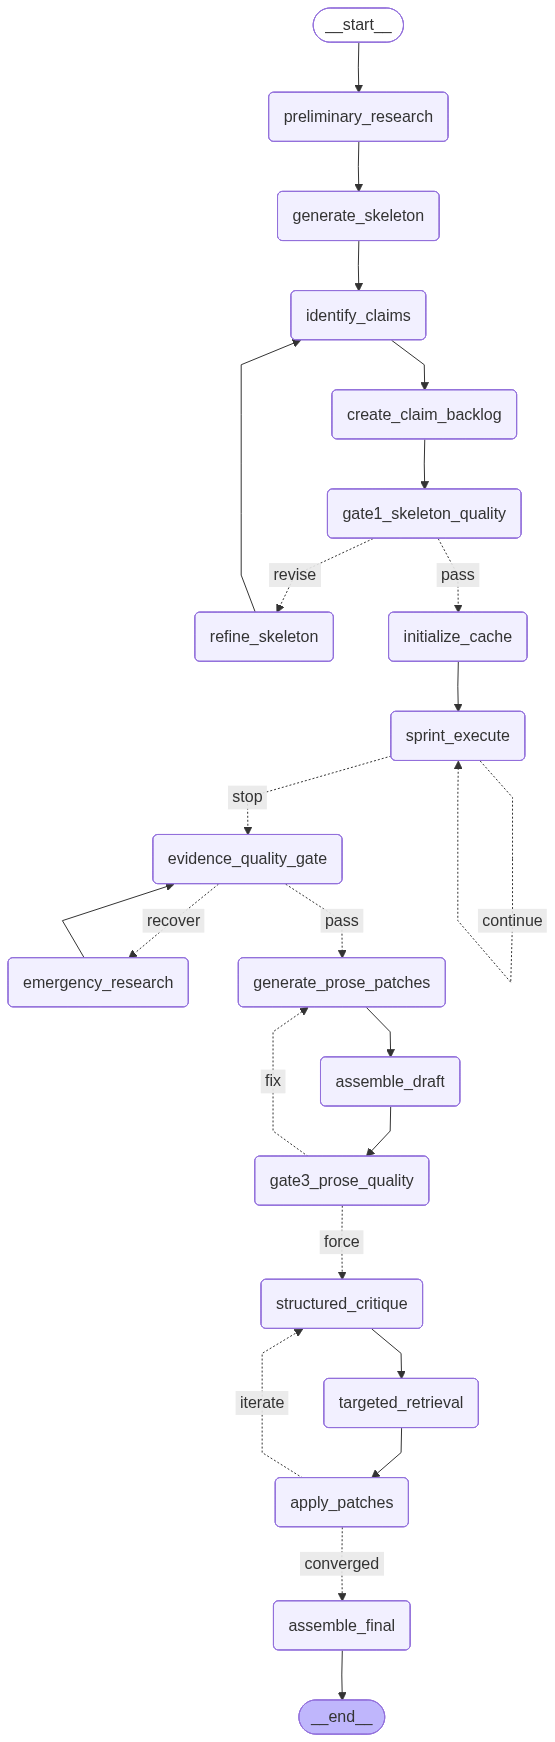

In [7]:
# Visualize the graph
from IPython.display import Image, display, Markdown

try:
    display(Image(combined_tier1_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

In [8]:
# ===== Agent Wrapper =====

async def combined_tier1_agent_async(inputs: dict) -> dict:
    """
    Async version of the Combined Tier 1 research agent.
    Use this version when calling from Jupyter notebooks.
    """
    global knowledge_base
    knowledge_base = None  # reset for a fresh session

    question = inputs.get("question", "")
    initial_state = init_state(question)

    result = await combined_tier1_graph.ainvoke(
        initial_state,
        config={"recursion_limit": 200}
    )

    cache_stats = knowledge_base.stats.copy() if knowledge_base else {}

    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "skeleton": result.get("skeleton", {}),
        "claims_registry": result.get("claims_registry", {}),
        "quality_scores": result.get("quality_scores", {}),
        "iteration_count": result.get("iteration_count", 0),
        "cache_stats": cache_stats,
        "gate_1_passed": result.get("gate1_passed", False),
        "gate_2_passed": result.get("gate2_passed", False),
        "gate_3_passed": result.get("gate3_passed", False),
        "gate_3_scores": {
            "word_count": result.get("gate3_word_count", 0),
            "reasoning": result.get("gate3_reasoning", "")
        }
    }


def combined_tier1_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for Combined Tier 1 research agent.
    Compatible with evaluation harness.
    """
    question = inputs.get("question", "")

    async def _execute():
        global knowledge_base
        knowledge_base = None
        initial_state = init_state(question)
        return await combined_tier1_graph.ainvoke(
            initial_state,
            config={"recursion_limit": 200}
        )

    try:
        loop = asyncio.get_running_loop()
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        result = asyncio.run(_execute())

    cache_stats = knowledge_base.stats.copy() if knowledge_base else {}

    return {
        "output": result.get("final_report", ""),
        "source_urls": list(set(result.get("source_urls", []))),
        "skeleton": result.get("skeleton", {}),
        "claims_registry": result.get("claims_registry", {}),
        "quality_scores": result.get("quality_scores", {}),
        "iteration_count": result.get("iteration_count", 0),
        "cache_stats": cache_stats,
    }


print("Agent wrappers defined")

Agent wrappers defined


In [9]:
# Manual test
# NOTE: This will run web searches and LLM calls.

test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print("Testing Combined Tier 1 Agent")
print(f"Question: {test_question}")
print("\nRunning combined architecture (this may take several minutes)...\n")

try:
    result = await combined_tier1_agent_async({"question": test_question})

    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    output = result.get("output", "")
    print(output[:4000] + "..." if len(output) > 4000 else output)

    print("\n" + "=" * 80)
    print("EXECUTION SUMMARY")
    print("=" * 80)
    print(f"Report length: {len(output)} chars, {len(output.split())} words")

    skeleton = result.get("skeleton")
    if hasattr(skeleton, "nodes"):
        node_count = len(skeleton.nodes)
    elif isinstance(skeleton, dict):
        node_count = len(skeleton.get("nodes", []))
    else:
        node_count = 0

    claims_registry = result.get("claims_registry", {})
    claims_count = len(claims_registry) if hasattr(claims_registry, "__len__") else 0

    print(f"Skeleton nodes: {node_count}")
    print(f"Claims tracked: {claims_count}")
    print(f"Refinement iterations: {result.get('iteration_count', 0)}")
    print(f"Quality progression: {result.get('quality_scores', [])}")
    print(f"Unique sources: {len(result.get('source_urls', []))}")

    print("\nGate Results:")
    print(f"  Gate 1 (Skeleton): {'PASSED' if result.get('gate_1_passed') else 'FAILED'}")
    print(f"  Gate 2 (Evidence): {'PASSED' if result.get('gate_2_passed') else 'FAILED'}")
    print(f"  Gate 3 (Prose): {'PASSED' if result.get('gate_3_passed') else 'FAILED'}")

    cache_stats = result.get("cache_stats", {})
    if cache_stats:
        total = cache_stats.get("total_queries", 0)
        avoided = cache_stats.get("web_searches_avoided", 0)
        hit_rate = avoided / total * 100 if total else 0
        print("\nCache Performance:")
        print(f"  Total queries: {total}")
        print(f"  Web searches avoided: {avoided} ({hit_rate:.1f}%)")
        print(f"  L1 hits: {cache_stats.get('l1_hits', 0)}")
        print(f"  L2 high: {cache_stats.get('l2_high', 0)}")
        print(f"  L2 medium: {cache_stats.get('l2_medium', 0)}")
        print(f"  L2 low: {cache_stats.get('l2_low', 0)}")

    print("\nAgent test PASSED")

except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

Testing Combined Tier 1 Agent
Question: What are the key benefits and challenges of using large language models in enterprise applications?

Running combined architecture (this may take several minutes)...

[2026-01-18T17:46:33.314926+00:00] Phase A: preliminary_research
[2026-01-18T17:46:44.342244+00:00] Phase A: preliminary_research complete
[2026-01-18T17:46:44.345123+00:00] Phase A: generate_skeleton
[2026-01-18T17:47:01.928701+00:00] Phase A: generate_skeleton complete | sections=6
[2026-01-18T17:47:01.929274+00:00] Phase A: identify_claims
[2026-01-18T17:47:39.042590+00:00] Phase A: identify_claims complete | claims=18
[2026-01-18T17:47:39.045780+00:00] Phase A: create_claim_backlog
[2026-01-18T17:48:02.580938+00:00] Phase A: create_claim_backlog complete | tasks=18
[2026-01-18T17:48:02.581450+00:00] Gate1: skeleton_quality attempt 1
[2026-01-18T17:48:19.052896+00:00] Gate1 result: score=8.00 pass=True
[2026-01-18T17:48:19.058023+00:00] Phase B: initialize_cache
[2026-01-18T17:48

In [10]:
display(Markdown(result["output"]))

# Integrating large language models (LLMs) into enterprise applications can drive significant gains in productivity, automation, customer experience, and knowledge discovery, but realizing those gains requires addressing technical, operational, legal, and ethical challenges—including model reliability (hallucinations), data privacy and compliance, bias and explainability, integration and latency, scalability and cost, and ongoing model lifecycle management—through robust engineering, governance, and monitoring frameworks.

## Introduction and scope

This section frames the research question, thesis, scope, primary use cases, stakeholders, and operational constraints for enterprise LLM adoption.

Research question and thesis: Can large language models (LLMs) be integrated into enterprise workflows to deliver measurable productivity, automation, customer experience, and knowledge-discovery gains while meeting enterprise reliability, compliance, and cost constraints? The short answer: yes, but only with explicit architecture, governance, and operational controls.

Scope and target use cases: Focus on three high-impact deployments for organizations with ≥500 employees — customer support automation (bot-assisted triage, draft responses, case summarization), internal knowledge search (semantic search over manuals, tickets, code, contracts), and document summarization (executive briefs, compliance extracts). Target users include frontline agents, knowledge workers, legal/compliance reviewers, product teams, and engineers. Primary data sources should be CRM/ticket systems, internal wikis, contract repositories, codebases, and audit logs. Define SLAs up front: uptime (e.g., 99.9%), end-to-end latency (median <300–500 ms for agent workflows), and quality thresholds (e.g., factuality/hallucination rate <X%, user satisfaction score improvement Y%).

Stakeholders and constraints: Product, engineering, security/compliance, legal, operations, and business owners must each own acceptance criteria. Constrain projects by data residency rules, approved vendor lists, minimum uptime SLAs, and budget ceilings tied to cost-per-request and total cost of ownership.

Mechanisms and operational patterns: Retrieval-augmented generation (RAG) or vector search ground outputs in corpora to reduce hallucinations. Apply access controls, encryption-in-transit/at-rest, VPC isolation, and audit trails to meet privacy requirements. Introduce human-in-the-loop verification for high-risk outputs and automated monitoring for drift, latency, and hallucination metrics. Optimize for cost and latency via model tiering (small models for low-risk tasks, large models for complex summarization), caching, and batching. Lifecycle management must include performance SLAs, regular model revalidation, prompt/version control, and ROI metrics (time saved per ticket, deflection rate, mean time to resolution).

Recommend initiating a limited production pilot with defined SLAs, instrumentation for hallucination and latency, legal/security sign-off, and a cross-functional steering committee.

Sources: learn.microsoft.com, startupsoft.com, petronellatech.com, straitsresearch.com

## Key benefits of LLMs in enterprises

Key benefits and measurable KPIs for LLM adoption

Large language models (LLMs) deliver four concrete enterprise gains: productivity, automation, customer experience, and knowledge discovery. Productivity: by augmenting knowledge workers and developers with code suggestions, summarization, and draft generation, LLMs shorten routine-task time and cut repetitive effort. Target pilot metrics: FTEs saved, time-to-completion, and automation rate; realistic reductions cluster in the 20–50% range for repetitive tasks, with developer task times reported up to ~30% faster in routine coding scenarios. Mechanism: embeddings plus context-aware generation reduce search and composition overhead, while prompt workflows and tool APIs surface high-value responses in one step. Automation: LLMs can automate decision-text generation, form-filling, and first-pass routing. Measure impact via automation rate (percent of tasks completed without human handoff), error rate, and cycle time; combine process mining to size opportunity and simulate FTE impact before scale-up. Customer experience: conversational LLM agents and assistive UI elements increase containment, shorten interactions, and improve resolution quality. Track CSAT, average handle time (AHT), and first-contact resolution (FCR); pilot targets of CSAT +5–15% are practical, and AHT reductions should align with the measured automation rate and containment gains. Mechanism: intent classification, dynamic retrieval, and response grounding (RAG) raise answer relevance while escalation thresholds preserve quality. Knowledge discovery: RAG/LLM systems transform search into precise Q&A, accelerating time-to-insight. Use precision@k, mean reciprocal rank (MRR), recall, and median query-to-answer time to quantify gains; expected outcomes are higher retrieval relevance and materially faster answer latency for enterprise documents when embeddings and curated context are used. Operationalize by instrumenting queries, human feedback loops, and periodic reindexing to sustain relevance.

Run focused pilots on high-volume repetitive tasks, contact-center flows, and knowledge hotspots, instrumenting the KPIs above and iterating on retrieval and safety controls.

Sources: linkedin.com, docs.uipath.com, robylon.ai, callminer.com

## Key challenges and risks

Key challenges and risks for enterprise LLM deployments — concise catalogue for decision makers.

Hallucinations: Models generate incorrect or fabricated outputs at non-trivial rates (commonly reported in the ~5–30% range depending on task and evaluation method). Measure this using QA-accuracy (correct answer rate) alongside a hallucination-rate metric (fraction of responses containing unsupported assertions). Mechanisms include probabilistic token prediction without grounding, training-data memorization, and failures in retrieval-augmented pipelines; an example impact is a customer-service assistant confidently returning an incorrect diagnosis that reduces downstream conversion and increases remediation cost. 

Data privacy & compliance: Risks arise when models access PII or regulated data through prompts, logged interactions, or training/finetuning datasets. Track exposures via number of data-exposure incidents, incidents per million queries, and audit-log completeness (percent of interactions with immutable, query-level provenance). Mechanistically, memorization of sensitive records and insecure connectors to internal systems drive incidents; business impacts range from regulatory fines and contractual penalties to class-action litigation and loss of customer trust. 

Bias and explainability: Manifestations include measurable demographic disparities (for example, demographic parity gaps or subgroup calibration errors) that erode stakeholder confidence. Include fairness metrics (demographic parity difference, equalized odds, subgroup calibration error) and explainability coverage (percent of high-risk decisions accompanied by model rationale or feature attributions) in risk inventories. Operationally, unexplained adverse outcomes increase legal exposure and slow product adoption. 

Integration, latency, cost, lifecycle management: Integration failures and mismatched SLAs elevate operational risk; high-latency inference harms UX, and inference/hosting costs scale with usage. Track end-to-end latency percentiles, cost per 1,000 queries, model-version proliferation, drift rates, and time-to-rollback. Mechanisms such as insufficient monitoring, absent canarying, and uncontrolled model updates translate into revenue loss, increased engineering burden, and degraded user trust. 

Evidence gap: Standardized, cross-industry benchmarks for enterprise incident rates (incidents per million queries) and their financial impacts remain limited.

Prioritize metrics, instrument monitoring, and require high-risk model controls (auditability, explainability, canarying) before broad rollout.

Sources: pmc.ncbi.nlm.nih.gov, arxiv.org, aclanthology.org, assurtiv.com

## Technical integration and operational considerations

Executive technical brief: integration and ops for RAG and LLM deployments

Recommendation summary — combine retrieval-augmented generation (RAG) with a vector database and grounded sources as the default architecture for knowledge-driven tasks, and apply targeted engineering controls to meet latency and throughput SLAs. Mechanism: encode documents and queries into dense embeddings, use a vector DB to retrieve a top-k context, rerank with a lightweight scorer, then condition the generative model on those grounded passages so outputs are constrained to verifiable sources. Validate effectiveness by running pre/post RAG QA experiments that measure exact-match or F1 accuracy and compute hallucination rates via human annotation or automated fact-checkers; compare confidence-calibrated output distributions to detect spurious generations. Meeting sub-300–500 ms latencies requires a stack of controls. First, select a smaller base model (quantized 4-bit/8-bit) or distilled variant to cut inference time, and consider encoder-decoder tradeoffs for generation speed. Second, implement multi-layer caching: embedding-cache for repeated queries, result-cache for frequent retrievals, and response-cache for idempotent queries. Third, apply batching, asynchronous request coalescing, and autoscaling with warm GPUs or CPU pools; prefer on-prem/edge placement for geo-sensitive, low-latency use cases and cloud for elastic burst capacity. Example: cache top-k retrievals per document shard and serve quantized 7B models on local GPUs to hit 200–300 ms P95 in pilot benchmarks. Fine-tuning vs. prompt engineering: fine-tuning typically raises task-specific accuracy and reduces per-query prompt complexity and token costs, but it requires labeled datasets, CI/CD for model artifacts, automated retraining pipelines, and validation suites for regressions. Operationalize with continuous evaluation (QA accuracy, hallucination rate, embedding drift), canary rollouts, explainability traces linking response tokens back to retrieval spans, and SLO/alerts on p95 latency, throughput, and factuality metrics. Evidence gap: enterprise-scale TCO comparisons between sustained fine-tuning pipelines and prompt-engineered deployments across multi-year horizons are limited.

Recommend a pilot: deploy RAG with a quantized 7B model, implement caching and autoscaling, and run pre/post QA and hallucination evaluations to establish baselines.

Sources: arxiv.org, cleanlab.ai, medium.com, medium.com

## Governance, legal, and ethical frameworks

Executive summary of recommended governance, legal, and ethical controls for data-driven systems.

Establish a single governance policy set that maps data classification to enforceable controls: tag data at ingestion (sensitive, regulated, public), apply retention rules and legal-hold overrides, and require lineage metadata for every dataset and model training artifact. Enforce role-based access control (RBAC) with least-privilege defaults and time-limited elevations; supplement with attribute-based controls for cross-jurisdiction or high-risk datasets so access decisions include purpose, location, and risk level. Capture immutable, append-only audit trails by combining write-once storage, cryptographic hashing of log blocks, and centralized SIEM ingestion to enable unverifiable chain-of-custody and forensic timelines. Automate retention and deletion via a policy engine integrated with data stores and workflow systems so retention, archival, and purge actions are auditable and block deletions under active legal hold.

Operationalize ethical controls through measurable rules. Run periodic bias audits (frequency tied to model risk tier; e.g., quarterly for high risk, annual for lower risk) that report disparate-impact and counterfactual-test results. Implement counterfactual testing pipelines that perturb sensitive attributes and measure outcome shifts; combine these with adversarial-scenario tests to reveal brittle behaviors. Require human-in-the-loop (HITL) gates for high-risk outputs with documented escalation paths and rollback capability. Track remediation with two metrics: audit frequency and remediation SLA (example targets: initial triage within 7 days, remediation closure within 30–90 days depending on severity). Document remediation plans, owners, and closure evidence in the audit record.

Manage legal risk through vendor risk assessments, mandatory data-processing agreements with purpose and use limitations, and explicit IP/derivative-work clauses clarifying model ownership and training-data rights. Include indemnity and insurance requirements proportional to vendor access level. Maintain an incident response playbook aligned to breach-notification SLAs (e.g., 72-hour regulator notification benchmark) with communication templates and tabletop schedules. Evidence gap: regulators do not universally prescribe specific audit frequencies or remediation SLAs, so policy-setting must combine legal minimums with risk-based internal standards.

Prioritize implementation by classifying data flows, enforcing RBAC and immutable logging, and standing up bias-audit pipelines; update vendor contracts and incident playbooks to reflect these controls.

Sources: secureprivacy.ai, cppa.ca.gov, concentric.ai, linkedin.com

## Implementation roadmap and best practices

Implementation roadmap and best practices for enterprise LLM adoption

Start with a tightly scoped proof-of-concept (6–12 weeks) that tests the core integration points: data connectivity, latency to model, retrieval-augmented generation accuracy, and end-to-end security. Require objective go/no-go gates at POC completion (example KPIs: baseline accuracy ≥ X, average inference latency ≤ 300 ms, and no uncontrolled data leakage). Progress to a controlled pilot (3–6 months) that exercises scale, user workflows, and A/B comparisons against incumbent processes; measure business KPIs such as mean handle time, conversion rate lift, and cost per useful response. Finally, pursue a phased enterprise rollout (6–12 months) with segmented cohorts, dark-launching high-risk flows, and formal change management. Enforce quantitative gates at each stage and hold periodic post-mortems. 

Architect the solution using hybrid inference patterns: route low-risk, high-volume queries to smaller, cheaper models and reserve larger models for complex tasks; colocate a lightweight retriever/vector store near the inference tier to reduce latency; and implement an orchestration layer that supports model routing, caching, and retry logic. Instrument a unified observability stack to capture uptime, latency percentiles, accuracy against labeled checks, and hallucination rate (measured via sampling and human review). Track cost metrics tightly: cost per useful response, cost per active user, and cost per transaction. Practical cost controls include model routing policies, response caching with TTLs, batching, and negotiating committed usage discounts with providers. 

Operational governance must codify model lifecycle processes: ownership, continuous monitoring for data and concept drift, scheduled retraining triggers, A/B testing frameworks for candidate models, and structured deprecation timelines. Establish SLAs and change controls for model updates, plus regular audits for safety and compliance. Evidence gap: quantitative, cross-industry studies validating typical TCO reductions of 25–60% from routing, caching, and negotiation strategies are limited.

Ready to translate this roadmap into a prioritized 12–18 month implementation plan with concrete resource and cost estimates.

Sources: spaceo.ai, researchgate.net, rohan-paul.com, elastic.co

## References
1. https://learn.microsoft.com/en-us/ai/playbook/technology-guidance/generative-ai/getting-started/llmops-checklist
2. https://startupsoft.com/llm-sensitive-data-best-practices-guide/
3. https://petronellatech.com/blog/enterprise-llmops-monitor-secure-and-prove-roi/
4. https://straitsresearch.com/report/enterprise-llm-market
5. https://www.linkedin.com/top-content/productivity/factors-influencing-workplace-productivity/impact-of-llm-quirks-on-workplace-productivity/
6. https://docs.uipath.com/process-mining/automation-cloud/latest/user-guide/simulating-automation-potential
7. https://robylon.ai/blog/top-12-ai-call-metrics-2026
8. https://callminer.com/blog/why-average-handle-time-still-matters
9. https://pmc.ncbi.nlm.nih.gov/articles/PMC12518350/
10. https://arxiv.org/html/2401.03205v1
11. https://aclanthology.org/2025.findings-emnlp.1035.pdf
12. https://assurtiv.com/data-privacy-trends-risk-report/
13. https://arxiv.org/abs/2403.10446
14. https://cleanlab.ai/blog/rag-tlm-hallucination-benchmarking/
15. https://medium.com/@rogt.x1997/40-fewer-hallucinations-cag-vs-rag-for-enterprise-ai-9cd1a64ad312
16. https://medium.com/@connect.hashblock/vector-db-testing-2030-the-roadmap-to-avoid-llm-hallucinations-ae640b95aca2
17. https://secureprivacy.ai/blog/ccpa-requirements-2026-complete-compliance-guide
18. https://cppa.ca.gov/regulations/pdf/ccpa_statute_eff_20260101.pdf
19. https://concentric.ai/how-role-based-access-control-rbac-helps-data-security-governance/
20. https://www.linkedin.com/posts/transformpartner_data-governance-executive-checklist-2026-activity-7416461246268583937-8nIM
21. https://www.spaceo.ai/blog/ai-implementation-roadmap/
22. https://www.researchgate.net/publication/396251075_LLM-Based_Data_Scie
23. https://www.rohan-paul.com/p/ml-interview-q-series-handling-llm
24. https://www.elastic.co/blog/2026-observability-trends-costs-business-impact

# Test Execution Section

This section runs the 5-query test dataset against this notebook variant and saves outputs for comparison.

**Output Structure:**
```
test_output/
    question_1/
        question_1_V08-3.md
    question_2/
        question_2_V08-3.md
    ...
```

**Instructions:**
1. Run all cells above first to define the agent
2. Run the cells below to execute all 5 test questions

In [ ]:
# Test Setup and Configuration
import os
import yaml
import json
from datetime import datetime
from pathlib import Path

# Configure paths
NOTEBOOK_DIR = Path('.').resolve()
OUTPUT_DIR = NOTEBOOK_DIR / 'test_output'
DATASET_PATH = NOTEBOOK_DIR / 'test_dataset.yaml'

# Notebook version (automatically set based on filename)
CURRENT_VERSION = "V08-3-V2"

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)

# Load test dataset
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    dataset = yaml.safe_load(f)

questions = dataset.get('questions', [])

# Create output directories for each question
for i in range(1, len(questions) + 1):
    question_dir = OUTPUT_DIR / f"question_{i}"
    question_dir.mkdir(exist_ok=True)

print(f"Test Configuration:")
print(f"  Version: {CURRENT_VERSION}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Loaded {len(questions)} test questions")
print(f"\nTest Questions:")
for i, q in enumerate(questions, 1):
    print(f"  {i}. [{q['category']}] {q['title']}")

Test Configuration:
  Version: V08-3
  Output directory: C:\Users\Gajanan Vigneswaran\OneDrive - Ryerson University\Desktop\Deep-Research-Agent\experimentation\notebooks\Phase 3\test_output
  Loaded 5 test questions

Test Questions:
  1. [market_intelligence] Pharmaceutical M&A Strategic Analysis
  2. [technical_scientific_research] Renewable Energy Technology Convergence
  3. [professional_specialized] Cross-Border CBDC Regulatory Landscape
  4. [product_solutions_comparison] Enterprise AI Document Processing Solutions
  5. [business_intelligence] Climate-Food Security Investment Analysis


In [10]:
def save_output(question_num: int, version: str, result: dict, question_data: dict) -> Path:
    """Save the output to a markdown file."""
    output_dir = OUTPUT_DIR / f"question_{question_num}"
    output_file = output_dir / f"question_{question_num}_{version}.md"
    
    question_text = question_data.get('question', '')
    question_title = question_data.get('title', 'Untitled')
    question_id = question_data.get('id', f'Q{question_num}')
    
    content = f"""# Question {question_num} - {version}

                **Question ID:** {question_id}  
                **Title:** {question_title}  
                **Category:** {question_data.get('category', 'N/A')}  

                ---

                ## Original Question

                {question_text}

                ---

                ## Research Report

                {result.get('output', 'No output generated')}

                """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(content)
    
    return output_file

print("Helper functions defined.")

Helper functions defined.


In [ ]:
overall_start = datetime.now()
start_time = datetime.now()
question_data = questions[0]
question_text = question_data['question']
i=1
try:
        result = await combined_tier1_agent_async({"question": question_text})
        elapsed = (datetime.now() - start_time).total_seconds()

        output_file = save_output(i, CURRENT_VERSION, result, question_data)

        summary = {
                "question": i,
                "title": question_data['title'],
                "version": CURRENT_VERSION,
                "elapsed_seconds": elapsed,
                "output_chars": len(result.get('output', '')),
                "sources": len(result.get('source_urls', [])),
                "status": "success"
        }

        print(f"Completed in {elapsed:.1f}s - {summary['output_chars']} chars, {summary['sources']} sources")

except Exception as e:
        elapsed = (datetime.now() - start_time).total_seconds()
        summary = {
                "question": i,
                "title": question_data['title'],
                "version": CURRENT_VERSION,
                "elapsed_seconds": elapsed,
                "output_chars": 0,
                "sources": 0,
                "status": f"error: {str(e)}"
        }
        print(f"FAILED: {e}")

print(summary)

[2026-01-24T07:09:53.531932+00:00] Phase A: preliminary_research
[2026-01-24T07:10:22.980809+00:00] Phase A: preliminary_research complete
[2026-01-24T07:10:22.984172+00:00] Phase A: generate_skeleton
[2026-01-24T07:10:37.573684+00:00] Phase A: generate_skeleton complete | sections=7
[2026-01-24T07:10:37.574710+00:00] Phase A: identify_claims
[2026-01-24T07:11:29.370707+00:00] Phase A: identify_claims complete | claims=21
[2026-01-24T07:11:29.374707+00:00] Phase A: create_claim_backlog
[2026-01-24T07:11:54.721124+00:00] Phase A: create_claim_backlog complete | tasks=21
[2026-01-24T07:11:54.731943+00:00] Gate1: skeleton_quality attempt 1
[2026-01-24T07:12:27.406204+00:00] Gate1 result: score=8.00 pass=True
[2026-01-24T07:12:27.419336+00:00] Phase B: initialize_cache
[2026-01-24T07:12:27.421334+00:00] Phase B: sprint_execute start | sprint=1 tasks=4
[2026-01-24T07:13:08.580833+00:00] Phase B: sprint_execute complete | coverage=0.19
[2026-01-24T07:13:08.585835+00:00] Phase B: sprint_execu

TypeError: string indices must be integers, not 'str'

In [16]:
output_file = save_output(i, CURRENT_VERSION, result, question_text)

## Run All Questions Test

Run ALL 5 questions for comprehensive testing:

**WARNING:** This will take 30-60+ minutes to complete.

In [ ]:
# Run ALL questions for the current version
# WARNING: This will take a long time (potentially 30-60+ minutes)

print(f"Running ALL {len(questions)} questions with {CURRENT_VERSION}")
print(f"Estimated time: 30-60+ minutes")
print("="*60 + "\n")

results_summary = []
overall_start = datetime.now()

for i, question_data in enumerate(questions, 1):
    question_text = question_data.get('question', '')
    
    print(f"\n{'='*60}")
    print(f"Question {i}/{len(questions)}: {question_data['title']}")
    print(f"{'='*60}\n")
    
    start_time = datetime.now()
    
    try:
        result = await combined_tier1_agent_async({"question": question_text})
        elapsed = (datetime.now() - start_time).total_seconds()
        
        output_file = save_output(i, CURRENT_VERSION, result, question_data)
        
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": len(result.get('output', '')),
            "sources": len(result.get('source_urls', [])),
            "status": "success"
        }
        
        print(f"Completed in {elapsed:.1f}s - {summary['output_chars']} chars, {summary['sources']} sources")
        
    except Exception as e:
        elapsed = (datetime.now() - start_time).total_seconds()
        summary = {
            "question": i,
            "title": question_data['title'],
            "version": CURRENT_VERSION,
            "elapsed_seconds": elapsed,
            "output_chars": 0,
            "sources": 0,
            "status": f"error: {str(e)}"
        }
        print(f"FAILED: {e}")
    
    results_summary.append(summary)

# Save summary
overall_elapsed = (datetime.now() - overall_start).total_seconds()

summary_file = OUTPUT_DIR / f"summary_{CURRENT_VERSION}.json"
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump({
        "run_time": datetime.now().isoformat(),
        "version": CURRENT_VERSION,
        "total_elapsed_seconds": overall_elapsed,
        "questions_tested": len(questions),
        "results": results_summary
    }, f, indent=2)

print(f"\n{'='*60}")
print(f"ALL TESTS COMPLETE for {CURRENT_VERSION}")
print(f"{'='*60}")
print(f"Total time: {overall_elapsed:.1f} seconds ({overall_elapsed/60:.1f} minutes)")
print(f"Summary saved: {summary_file}")